In [1]:
from pathlib import Path

import cv2
import insightface
import numpy as np
from PIL import Image

## load model

In [2]:
model = insightface.app.FaceAnalysis()
model.prepare(ctx_id=-1, nms=0.4) # prepare the enviorment; nms threshold is set to 0.4

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


## generate face database

In [3]:
%%time
faces_list = list()
for file in Path('./faces').iterdir():
    face = model.get(cv2.imread(str(file)))[0] # each example image must contain only 1 face
    features_dict = dict()
    features_dict['name'] = file.stem
    features_dict['age'] = face.age
    features_dict['gender'] = 'female' if face.gender==0 else 'male'
    features_dict['embedding'] = face.embedding
    faces_list.append(features_dict)

np.save('./faces.npy', faces_list)

CPU times: user 9.5 s, sys: 229 ms, total: 9.72 s
Wall time: 2.68 s


In [4]:
database = np.load('./faces.npy', allow_pickle=True)[()]
database[0].keys()

dict_keys(['name', 'age', 'gender', 'embedding'])

## inference

In [5]:
def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1)*np.linalg.norm(vector2))
                                       
def identify(embedding, database):
    comparison_scores = list()
    for face in database:
        comparison_scores.append(cosine_similarity(face['embedding'], embedding))
    return database[np.array(comparison_scores).argmax()]['name'] if np.max(comparison_scores) > 0.6 else ''

def test_image(image, database, model):
    for face in model.get(image):
        x, y, x2, y2 = face.bbox.astype(np.int).flatten()
        cv2.rectangle(image, (x, y), (x2, y2), (0,255,0), 2)
        cv2.putText(image, identify(face.embedding, database), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
    return image

In [6]:
test_image_1 = cv2.imread('tests/images/MSAI Group Photo.jpg') 
test_image_2 = cv2.imread('tests/images/Deloitte Interns.jpg')

CPU times: user 43.8 s, sys: 1.26 s, total: 45.1 s
Wall time: 11 s


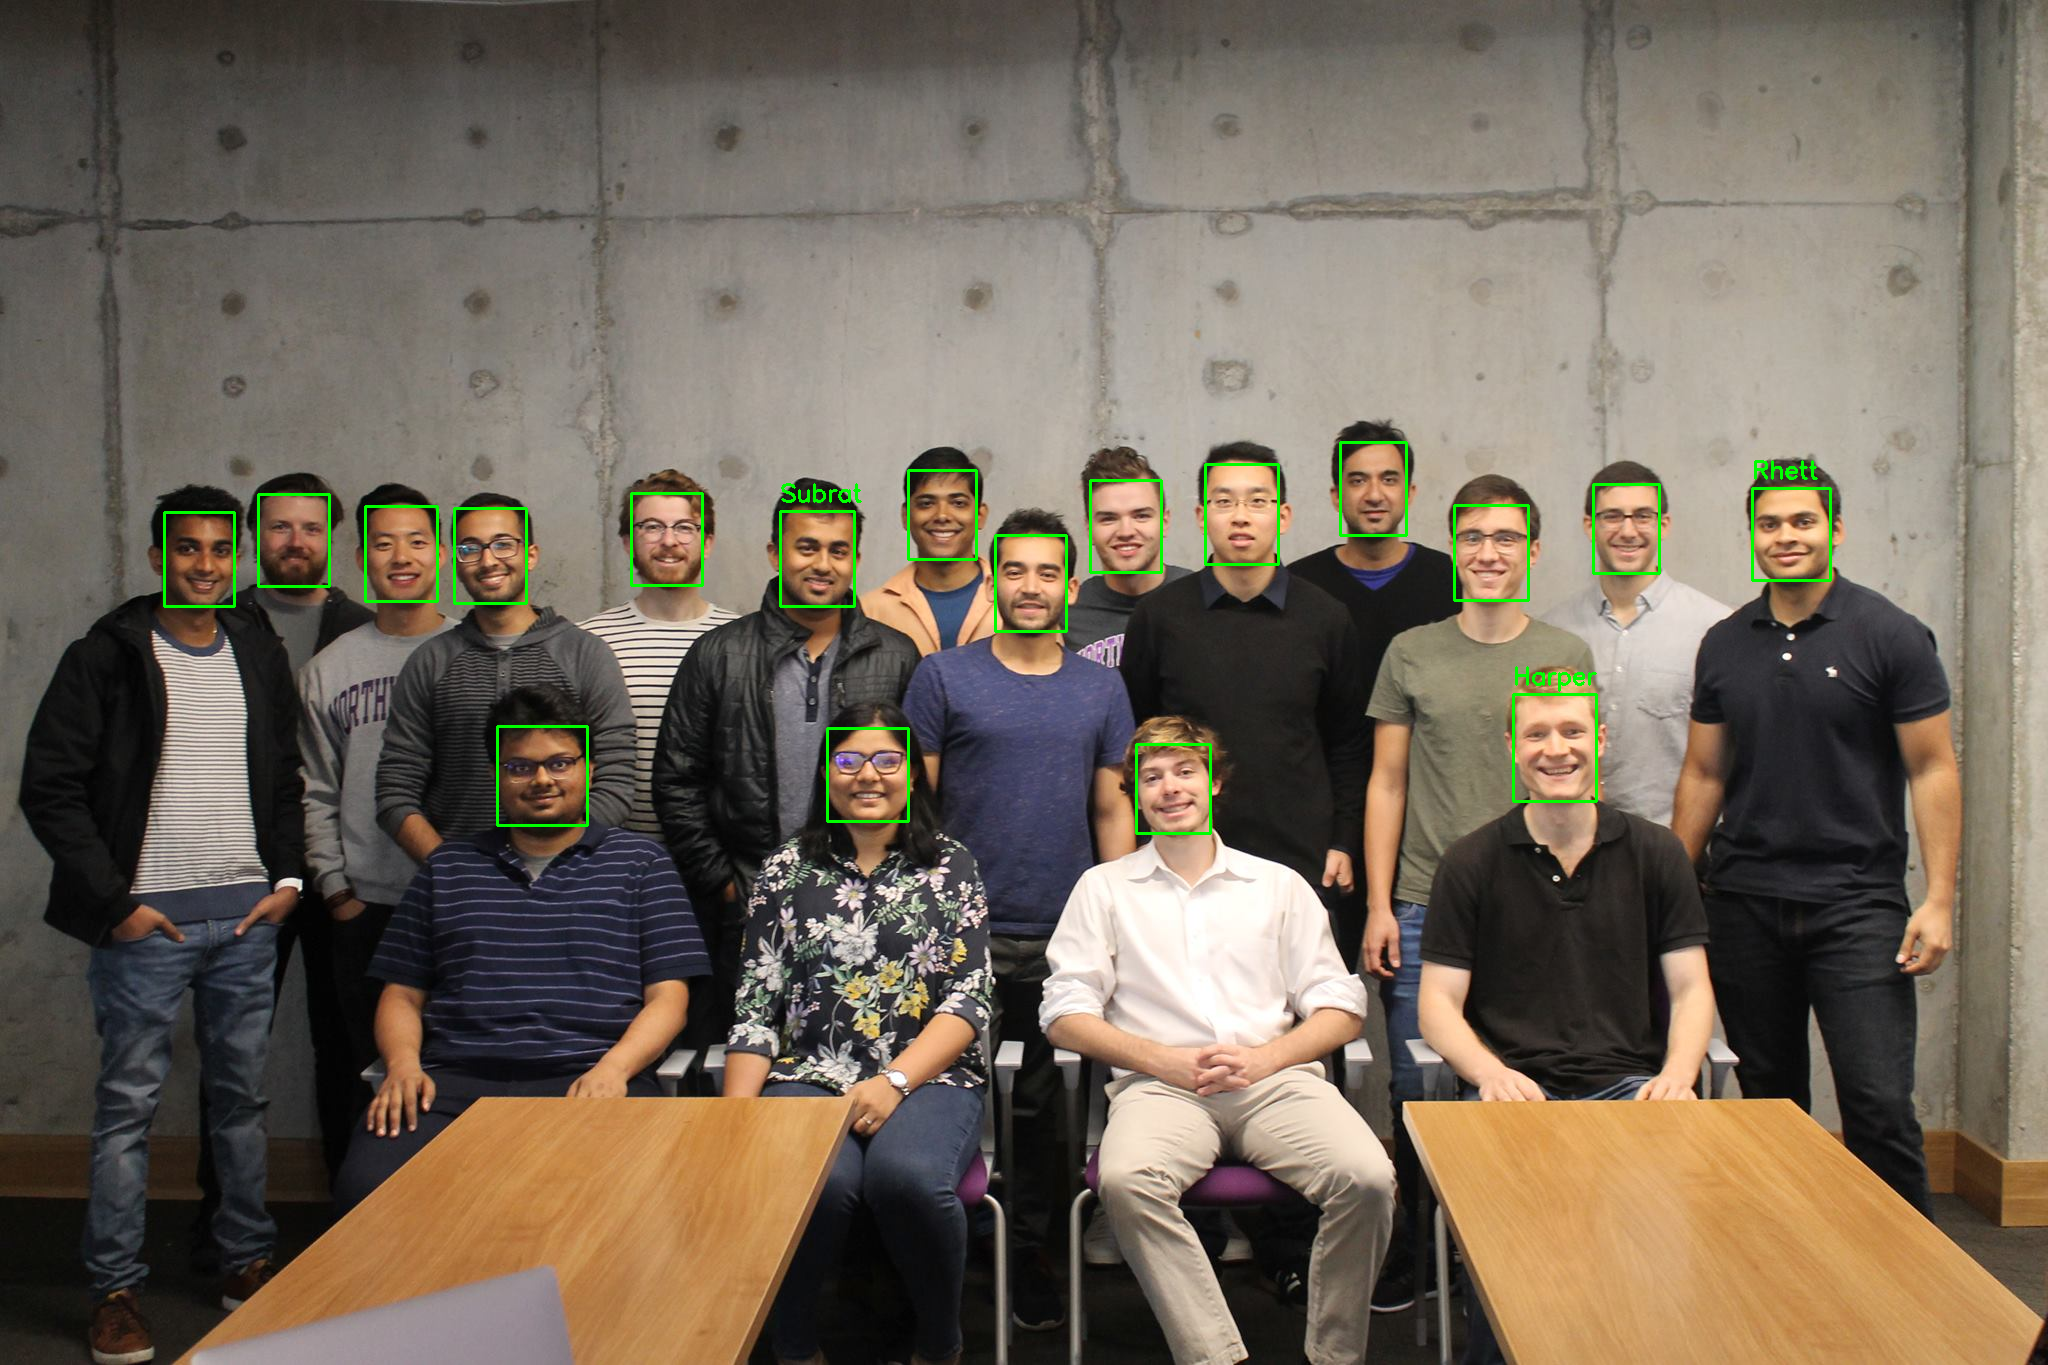

In [7]:
%%time
Image.fromarray(test_image(test_image_1, database, model)[:, :, ::-1]) # convert OpenCV's BGR channel order to RGB

CPU times: user 20 s, sys: 212 ms, total: 20.3 s
Wall time: 4.8 s


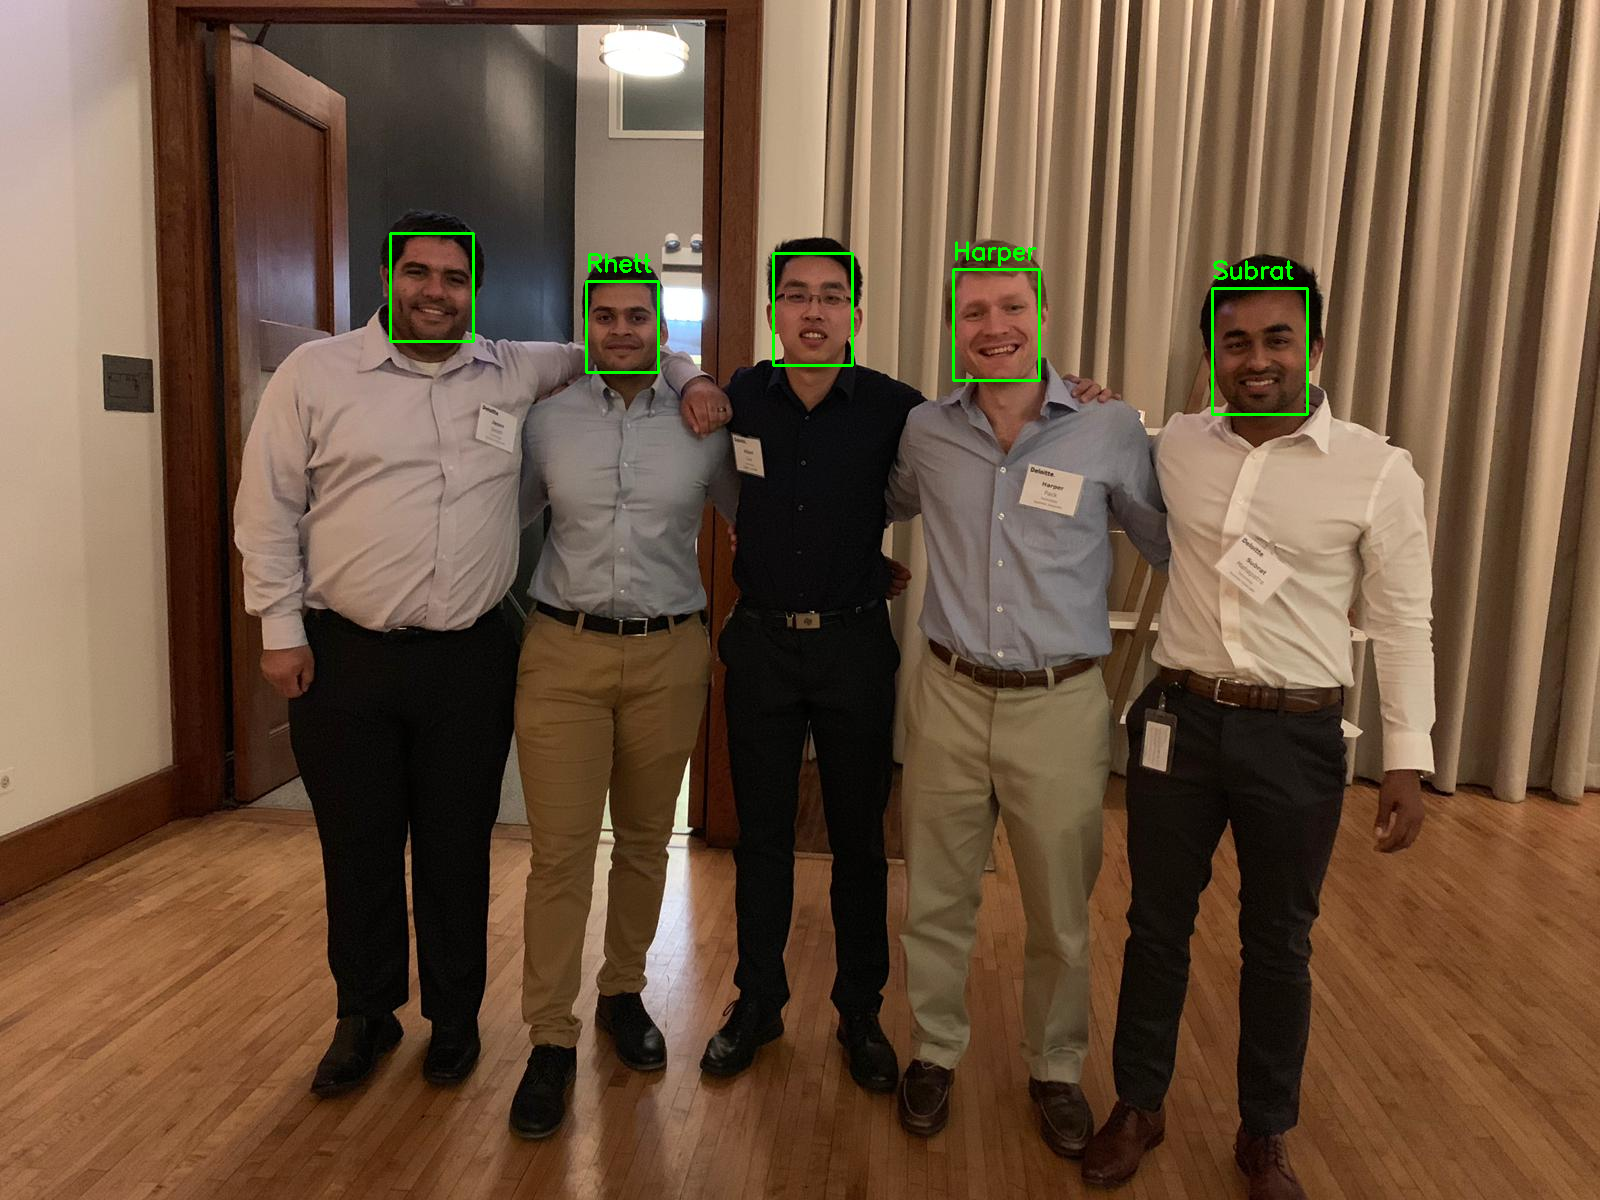

In [8]:
%%time
Image.fromarray(test_image(test_image_2, database, model)[:, :, ::-1]) 